In [1]:
import pandas as pd
import sqlite3
from tqdm.notebook import tqdm
import numpy as np

In [ ]:
db name - hop_db
table names - hop / npidata / taxonomy/ zip_to_cbsa

In [2]:
# Create the hop_team SQLite database
db = sqlite3.connect('hop_db.sqlite')

In [3]:
pd.set_option('display.max_columns', None)

In [ ]:
# Create the hop_team SQLite database
db = sqlite3.connect('hop_db.sqlite')

# create the referrals table and add it to the database
for chunk in tqdm(pd.read_csv('DocGraph_Hop_Teaming_2018.csv', chunksize = 10000)):
    # Do some preemptive filtering for likely "accidental" referrals
    chunk = chunk.loc[(chunk['transaction_count'] >= 25) & (chunk['std_day_wait'] < 90)]
    # append to referrals table
    chunk.to_sql('hop', db, if_exists = 'append', index = False)

In [17]:
# Create the hop_team SQLite database
db = sqlite3.connect('hop_db.sqlite')

# create the referrals table and add it to the database
for chunk in tqdm(pd.read_csv('DocGraph_Hop_Teaming_2018.csv', chunksize = 10000)):
    # Do some preemptive filtering for likely "accidental" referrals
    chunk = chunk.loc[(chunk['transaction_count'] >= 50) & (chunk['std_day_wait'] < 50)]
    # append to referrals table
    chunk.to_sql('hop_2', db, if_exists = 'append', index = False)

0it [00:00, ?it/s]

In [10]:
taxonomy = pd.read_csv('nucc_taxonomy_230.csv', encoding = 'latin1')

In [11]:
taxonomy.to_sql('taxonomy', db, if_exists = 'append', index = False)

873

In [12]:
zip_cbsa = pd.read_excel('ZIP_CBSA_122021.xlsx')

In [14]:
zip_cbsa.to_sql('zip_to_cbsa', db, if_exists = 'append', index = False)

47484

In [ ]:
# Old code but may use later on

# Monica's magic loop!
def get_primary_taxonomy(row):
    for n in range(1, 16):
        if row['primary_taxonomy'] == '':
            x = str(n)
            if row[f'Healthcare Provider Primary Taxonomy Switch_{x}'] == 'Y':
                return row[f'Healthcare Provider Taxonomy Code_{x}']
    return row['primary_taxonomy']

# Define list of relevant columns
cols = ['NPI', 'Entity Type Code', 
        'Provider Organization Name (Legal Business Name)',
        'Provider Last Name (Legal Name)', 'Provider First Name', 
        'Provider Middle Name', 'Provider Name Prefix Text',
        'Provider Name Suffix Text', 'Provider Credential Text',
        'Provider First Line Business Practice Location Address',
        'Provider Second Line Business Practice Location Address',
        'Provider Business Practice Location Address City Name',
        'Provider Business Practice Location Address State Name',
        'Provider Business Practice Location Address Postal Code']

# Append taxonomy columns 1 to 15
for i in range(1, 16):
    cols.append(f'Healthcare Provider Primary Taxonomy Switch_{i}')
    cols.append(f'Healthcare Provider Taxonomy Code_{i}')

# Read in CSV and relevant columns in chunks
chunksize = 1000000
npi_chunks = pd.read_csv('npidata_pfile_20050523-20230212.csv', usecols = cols, low_memory = False, chunksize = chunksize)

# Define empty dataframe
npi_test = pd.DataFrame()

# Loop over the chunks and process the data
for chunk in npi_chunks:
    # Process data with apply function
    chunk['primary_taxonomy'] = ''
    chunk['primary_taxonomy'] = chunk.apply(get_primary_taxonomy, axis = 1)

    # Append processed data to the empty dataframe
    npi_test = pd.concat([npi_test, chunk])

# Read in other csv files with type cleaning    
nucc = pd.read_csv('nucc_taxonomy_230.csv', encoding = 'latin1')
zip = pd.read_csv('ZIP_CBSA_122021.csv', dtype = {'zip': str})
zip['cbsa'] = zip['cbsa'].astype(str)

# Merge and edit zip codes
merged_df = pd.merge(npi_test, nucc[['Code', 'Classification']], left_on = 'primary_taxonomy', right_on = 'Code', how = 'left')
merged_df['Provider Business Practice Location Address Postal Code'] = merged_df['Provider Business Practice Location Address Postal Code'].str[:5]
merged_df = pd.merge(merged_df, zip[['zip', 'cbsa']], left_on = 'Provider Business Practice Location Address Postal Code', right_on = 'zip', how = 'left')

merged_df.tail(25)

In [22]:
query = """
SELECT n.npi, n.organization_name
FROM npidata n
INNER JOIN taxonomy t 
ON n.taxonomy_code = t.Code
WHERE n.entity_type_code = 2
  AND n.practice_location_address_city_name = 'NASHVILLE'
  AND n.practice_location_address_state_name = 'TN'
  AND t.classification = 'General Acute Care Hospital'
"""

with sqlite3.connect('hop_db.sqlite') as db: 
    hospitals = pd.read_sql(query, db)
    
db.close()
hospitals

,npi,organization_name
0,1609056399,VANDERBILT CHILDREN'S
1,1326224015,VANDERBILT CHILDRENS HOSPITAL
2,1609970029,"BUCKS COUNTY ONCOPLASTIC INSTITUTE, LLC"
3,1164609319,VANDERBILT MEDICAL CENTER
4,1992861314,SETON CORPORATION
5,1477709053,VANDERBILT UNIVERSITY MEDICAL CENTER
6,1255577466,MONROE CARELL JR VANDERBILT CHILDREN'S HOSPITAL
7,1396983680,"ST. THOMAS NP, LLC"
8,1366679276,VANDERBILT UNIVERSITY MEDICAL CENTER
9,1518112440,NASHVILLE REHAB LLC


In [23]:
hospitals.nunique()

npi                  55
organization_name    27
dtype: int64

In [16]:
query = '''
SELECT *
FROM hop
INNER JOIN npidata n1
ON hop.from_npi = n1.npi
INNER JOIN npidata n2
ON hop.to_npi = n2.npi
WHERE n1.entity_type_code = 1
    AND n2.practice_location_address_city_name = 'NASHVILLE'
    AND n2.practice_location_address_state_name = 'TN'
    AND n2.entity_type_code = 2;
'''
with sqlite3.connect('hop_db.sqlite') as db: 
    total_nashville = pd.read_sql(query, db)
    
db.close()
total_nashville

,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix,name_suffix,credential,first_line_practice_location_address,second_line_practice_location_address,practice_location_address_city_name,practice_location_address_state_name,practice_location_address_postal_code,taxonomy_code,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix,name_suffix,credential,first_line_practice_location_address,second_line_practice_location_address,practice_location_address_city_name,practice_location_address_state_name,practice_location_address_postal_code,taxonomy_code
0,1528054798,1700900040,36,39,0.026,0.160,1528054798,1.0,None,RAY,JAMES,E,None,None,CRNA,110 29TH AVE N,STE 202,NASHVILLE,TN,37203,367500000X,1700900040,2.0,JEFFREY D HORN MD PLLC,None,None,None,None,None,None,2011 CHURCH ST,SUITE 801,NASHVILLE,TN,37203,207W00000X
1,1609862804,1700900040,44,48,0.000,0.000,1609862804,1.0,None,MORRISON,JAMIE,S,None,None,CRNA,5717 CLOVERWOOD DR,None,BRENTWOOD,TN,37027,367500000X,1700900040,2.0,JEFFREY D HORN MD PLLC,None,None,None,None,None,None,2011 CHURCH ST,SUITE 801,NASHVILLE,TN,37203,207W00000X
2,1013026806,1700900040,43,44,0.000,0.000,1013026806,1.0,None,NANCE,FAITH,None,MISS,None,CRNA,110 29TH AVE N STE 202,None,NASHVILLE,TN,37203,367500000X,1700900040,2.0,JEFFREY D HORN MD PLLC,None,None,None,None,None,None,2011 CHURCH ST,SUITE 801,NASHVILLE,TN,37203,207W00000X
3,1023269016,1700900040,28,28,0.000,0.000,1023269016,1.0,None,PETERSON,MARLA,JEAN,MRS.,None,CRNA,267 GRANT ST,BRIDGEPORT HOSPITAL,BRIDGEPORT,CT,06610,367500000X,1700900040,2.0,JEFFREY D HORN MD PLLC,None,None,None,None,None,None,2011 CHURCH ST,SUITE 801,NASHVILLE,TN,37203,207W00000X
4,1093753303,1700900040,58,63,67.063,55.572,1093753303,1.0,None,WELCH,DEREK,C.,DR.,None,M.D.,1010 AIRPARK CENTER DR,None,NASHVILLE,TN,37217,207ZP0102X,1700900040,2.0,JEFFREY D HORN MD PLLC,None,None,None,None,None,None,2011 CHURCH ST,SUITE 801,NASHVILLE,TN,37203,207W00000X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271638,1568687812,1104850130,38,43,51.256,57.570,1568687812,1.0,None,BUSTOS,DANIEL,E.,None,None,M.D.,1725 MEDICAL CENTER PKWY STE 200,None,MURFREESBORO,TN,37129,207W00000X,1104850130,2.0,HEIKKI E KOSTAMAA MD PC,None,None,None,None,None,None,28 WHITE BRIDGE PIKE,STE. 208,NASHVILLE,TN,37205,207W00000X
271639,1598751810,1104850130,28,29,85.345,67.663,1598751810,1.0,None,PODGORSKI,GARY,T.,DR.,None,MD,1224 TROTWOOD AVE,"SOUTHERN RADIOLOGY ASSOCIATES, PLL",COLUMBIA,TN,38401,2085R0202X,1104850130,2.0,HEIKKI E KOSTAMAA MD PC,None,None,None,None,None,None,28 WHITE BRIDGE PIKE,STE. 208,NASHVILLE,TN,37205,207W00000X
271640,1285615385,1104850130,18,25,22.920,23.045,1285615385,1.0,None,HANEY,CHARLES,DOUGLAS,DR.,None,M.D.,215 S CEDAR LN,None,PULASKI,TN,38478,207Q00000X,1104850130,2.0,HEIKKI E KOSTAMAA MD PC,None,None,None,None,None,None,28 WHITE BRIDGE PIKE,STE. 208,NASHVILLE,TN,37205,207W00000X
271641,1508064890,1104850130,26,26,78.231,61.877,1508064890,1.0,None,SMITH,MARVIN,MONTGOMERY,None,None,M.D.,1224 TROTWOOD AVE,DEPT OF RADIOLOGY,COLUMBIA,TN,38401,2085R0202X,1104850130,2.0,HEIKKI E KOSTAMAA MD PC,None,None,None,None,None,None,28 WHITE BRIDGE PIKE,STE. 208,NASHVILLE,TN,37205,207W00000X


In [7]:
query = '''
SELECT *
FROM zip_to_cbsa
LIMIT 1
'''
with sqlite3.connect('hop_db.sqlite') as db: 
    zip_index = pd.read_sql(query, db)
    
db.close()
zip_index

,zip,cbsa,city,state,res_ratio,bus_ratio,oth_ratio,tot_ratio
0,00683,41900,SAN GERMAN,PR,0.999842,1.0,1.0,0.999855


In [8]:
query = '''
SELECT *
FROM hop
LIMIT 1
'''
with sqlite3.connect('hop_db.sqlite') as db: 
    hop_index = pd.read_sql(query, db)
    
db.close()
hop_index

,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait
0,1508062167,1730166109,350,370,53.922,72.612


In [13]:
query = '''
SELECT *
FROM npidata
LIMIT 10
'''
with sqlite3.connect('hop_db.sqlite') as db: 
    npi_index = pd.read_sql(query, db)
    
db.close()
npi_index

,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix,name_suffix,credential,first_line_practice_location_address,second_line_practice_location_address,practice_location_address_city_name,practice_location_address_state_name,practice_location_address_postal_code,taxonomy_code
0,1740284231,None,None,None,None,None,None,None,None,None,None,None,None,00nan,None
1,1346245800,None,None,None,None,None,None,None,None,None,None,None,None,00nan,None
2,1487650776,None,None,None,None,None,None,None,None,None,None,None,None,00nan,None
3,1033113022,None,None,None,None,None,None,None,None,None,None,None,None,00nan,None
4,1043216138,None,None,None,None,None,None,None,None,None,None,None,None,00nan,None
5,1104820703,None,None,None,None,None,None,None,None,None,None,None,None,00nan,None
6,1811996671,None,None,None,None,None,None,None,None,None,None,None,None,00nan,None
7,1225030232,None,None,None,None,None,None,None,None,None,None,None,None,00nan,None
8,1194711135,None,None,None,None,None,None,None,None,None,None,None,None,00nan,None
9,1407848740,None,None,None,None,None,None,None,None,None,None,None,None,00nan,None


In [10]:
query = '''
SELECT *
FROM taxonomy
LIMIT 1
'''
with sqlite3.connect('hop_db.sqlite') as db: 
    tax_index = pd.read_sql(query, db)
    
db.close()
tax_index

,Code,Grouping,Classification,Specialization,Definition,Notes,Display Name,Section
0,193200000X,Group,Multi-Specialty,None,A business group of one or more individual pra...,[7/1/2003: new],Multi-Specialty Group,Individual


In [12]:
# Create Indices
db = sqlite3.connect('hop_db.sqlite')

db.execute('CREATE INDEX hop_from_npi_idx ON hop(from_npi);')
db.execute('CREATE INDEX hop_to_npi_idx ON hop(to_npi);')
db.execute('CREATE INDEX transact_npi_idx ON hop(transaction_count);')
db.execute('CREATE INDEX patient_npi_idx ON hop(patient_count);')

db.execute('CREATE INDEX npidata_npi_idx ON npidata(npi);')
db.execute('CREATE INDEX npidata_entity_type_code_idx ON npidata(entity_type_code);')
db.execute('CREATE INDEX org_code_idx ON npidata(organization_name);')
db.execute('CREATE INDEX city_code_idx ON npidata(practice_location_address_city_name);')
db.execute('CREATE INDEX state_code_idx ON npidata(practice_location_address_state_name);')
db.execute('CREATE INDEX zip_code_idx ON npidata(practice_location_address_postal_code);')
db.execute('CREATE INDEX tax_code_idx ON npidata(taxonomy_code);')

db.execute('CREATE INDEX taxonomy_code_idx ON taxonomy(Code);')
db.execute('CREATE INDEX class_code_idx ON taxonomy(Classification);')
db.execute('CREATE INDEX name_code_idx ON taxonomy("Display Name");')

db.execute('CREATE INDEX zip_to_cbsa_zip_idx ON zip_to_cbsa(zip);')
db.execute('CREATE INDEX zip_to_cbsa_cbsa_idx ON zip_to_cbsa(cbsa);')

db.close()

In [19]:
db = sqlite3.connect('hop_db.sqlite')

db.execute('CREATE INDEX hop2_from_npi_idx ON hop_2(from_npi);')
db.execute('CREATE INDEX hop2_to_npi_idx ON hop_2(to_npi);')
db.execute('CREATE INDEX transact2_npi_idx ON hop_2(transaction_count);')
db.execute('CREATE INDEX patient2_npi_idx ON hop_2(patient_count);')

db.close()

In [20]:
query = '''
SELECT *
FROM hop_2
INNER JOIN npidata n1
ON hop_2.from_npi = n1.npi
INNER JOIN npidata n2
ON hop_2.to_npi = n2.npi
WHERE n1.entity_type_code = 1
    AND n2.practice_location_address_city_name = 'NASHVILLE'
    AND n2.practice_location_address_state_name = 'TN'
    AND n2.entity_type_code = 2;
'''
with sqlite3.connect('hop_db.sqlite') as db: 
    total_nashville2 = pd.read_sql(query, db)
    
db.close()
total_nashville2

,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix,name_suffix,credential,first_line_practice_location_address,second_line_practice_location_address,practice_location_address_city_name,practice_location_address_state_name,practice_location_address_postal_code,taxonomy_code,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix,name_suffix,credential,first_line_practice_location_address,second_line_practice_location_address,practice_location_address_city_name,practice_location_address_state_name,practice_location_address_postal_code,taxonomy_code
0,1134210149,1700900040,454,1016,0.000,0.000,1134210149,1.0,None,HORN,JEFFREY,D,None,None,MD,2011 CHURCH ST,SUITE 801,NASHVILLE,TN,37203,207W00000X,1700900040,2.0,JEFFREY D HORN MD PLLC,None,None,None,None,None,None,2011 CHURCH ST,SUITE 801,NASHVILLE,TN,37203,207W00000X
1,1811905409,1548450513,59,83,8.193,30.203,1811905409,1.0,None,ALI,FATHI,IDRIS,None,None,M.D.,1220 TROTWOOD AVE,SUITE 401,COLUMBIA,TN,38401,207RC0000X,1548450513,2.0,"MARY A. MCELANEY, M.D.",None,None,None,None,None,None,397 WALLACE RD,SUITE 415,NASHVILLE,TN,37211,207RP1001X
2,1568410363,1548450513,48,77,13.312,36.028,1568410363,1.0,None,JAIN,YUGESH,K,None,None,MD,3443 DICKERSON PIKE,SUITE G-30,NASHVILLE,TN,37207,207R00000X,1548450513,2.0,"MARY A. MCELANEY, M.D.",None,None,None,None,None,None,397 WALLACE RD,SUITE 415,NASHVILLE,TN,37211,207RP1001X
3,1689647489,1548450513,29,51,20.118,46.529,1689647489,1.0,None,PATEL,ILABEN,BHAGUBHAI,DR.,None,M.D.,3601 THE VANDERBILT CLINIC,None,NASHVILLE,TN,37232,207Q00000X,1548450513,2.0,"MARY A. MCELANEY, M.D.",None,None,None,None,None,None,397 WALLACE RD,SUITE 415,NASHVILLE,TN,37211,207RP1001X
4,1003876236,1548450513,50,60,24.767,48.130,1003876236,1.0,None,KUHN,KARL,P,None,None,MD,397 WALLACE RD,STE 415,NASHVILLE,TN,37211,207RP1001X,1548450513,2.0,"MARY A. MCELANEY, M.D.",None,None,None,None,None,None,397 WALLACE RD,SUITE 415,NASHVILLE,TN,37211,207RP1001X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29929,1265884050,1124443403,12,75,0.000,0.000,1265884050,1.0,None,WILLIAMS,KATIE,SAMANTHA,None,None,FNP-C,333 COMMERCE ST STE 700,None,NASHVILLE,TN,37201,363LP2300X,1124443403,2.0,"ASPIRE HEALTH MEDICAL PARTNERS, PC",None,None,None,None,None,None,22 CENTURY BLVD STE 220,None,NASHVILLE,TN,37214,207RH0002X
29930,1932600103,1124443403,16,64,0.000,0.000,1932600103,1.0,None,SAMS,AISHA,None,MRS.,None,NP,333 COMMERCE ST STE 700,None,NASHVILLE,TN,37201,363LG0600X,1124443403,2.0,"ASPIRE HEALTH MEDICAL PARTNERS, PC",None,None,None,None,None,None,22 CENTURY BLVD STE 220,None,NASHVILLE,TN,37214,207RH0002X
29931,1376080960,1124443403,14,53,0.000,0.000,1376080960,1.0,None,BEARD,LINDSEY,None,None,None,None,411 WATER OAK DR,None,SEYMOUR,TN,37865,363LF0000X,1124443403,2.0,"ASPIRE HEALTH MEDICAL PARTNERS, PC",None,None,None,None,None,None,22 CENTURY BLVD STE 220,None,NASHVILLE,TN,37214,207RH0002X
29932,1427046622,1902894330,23,74,3.797,9.352,1427046622,1.0,None,LAYA,LISA,None,DR.,None,MD,3515 CENTRAL PIKE,STE 105,HERMITAGE,TN,37076,207RI0200X,1902894330,2.0,"I V SOLUTIONS, INC.",None,None,None,None,None,None,217 W MAPLEWOOD LANE,None,NASHVILLE,TN,37207,3336H0001X


practice_location_address_city_name
practice_location_address_state_name
practice_location_address_postal_code
display_name

In [42]:
query = '''
SELECT npidata.organization_name, COUNT(*) as count_referrals
FROM hop
INNER JOIN npidata ON hop.to_npi = npidata.npi
INNER JOIN taxonomy ON npidata.taxonomy_code = taxonomy.Code
WHERE hop.from_npi IN (
  SELECT npi FROM npidata WHERE entity_type_code = 1
    )
AND npidata.entity_type_code = 2
AND taxonomy."Display Name" = 'General Acute Care Hospital'
AND npidata.practice_location_address_city_name = 'NASHVILLE'
AND npidata.practice_location_address_state_name = 'TN'
GROUP BY npidata.organization_name, taxonomy.Classification
ORDER BY count_referrals DESC;
'''
with sqlite3.connect('hop_db.sqlite') as db: 
    nash_referrals = pd.read_sql(query, db)
    
db.close()
nash_referrals

,organization_name,count_referrals
0,VANDERBILT UNIVERSITY MEDICAL CENTER,12731
1,SAINT THOMAS WEST HOSPITAL,6652
2,"HCA HEALTH SERVICES OF TENNESSEE, INC.",5225
3,HTI MEMORIAL HOSPITAL CORPORATION,1634
4,NASHVILLE GENERAL HOSPITAL,191
5,SETON CORPORATION,26


In [13]:
query = '''
SELECT *, t."Display Name"
FROM hop
INNER JOIN npidata n1 ON hop.from_npi = n1.npi
INNER JOIN npidata n2 ON hop.to_npi = n2.npi
INNER JOIN taxonomy t ON n1.taxonomy_code = t.Code
WHERE n1.entity_type_code = 1
AND n2.practice_location_address_city_name = 'NASHVILLE'
AND n2.practice_location_address_state_name = 'TN'
AND t."Display Name" = 'General Acute Care Hospital'
AND n2.entity_type_code = 2;
'''
with sqlite3.connect('hop_db.sqlite') as db: 
    display_names = pd.read_sql(query, db)
    
db.close()
display_names

,from_npi,to_npi,patient_count,transaction_count,average_day_wait,std_day_wait,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix,name_suffix,credential,first_line_practice_location_address,second_line_practice_location_address,practice_location_address_city_name,practice_location_address_state_name,practice_location_address_postal_code,taxonomy_code,npi,entity_type_code,organization_name,last_name,first_name,middle_name,name_prefix,name_suffix,credential,first_line_practice_location_address,second_line_practice_location_address,practice_location_address_city_name,practice_location_address_state_name,practice_location_address_postal_code,taxonomy_code,Code,Grouping,Classification,Specialization,Definition,Notes,Display Name,Section,Display Name
0,1730429598,1528422086,16,28,13.786,14.528,1730429598,1.0,None,ARULTHASAN,VAITHILINGAM,None,None,None,MD,355 BARD AVE,None,STATEN ISLAND,NY,10310,282N00000X,1528422086,2.0,DCI LABORATORY LLC,None,None,None,None,None,None,2917 FOSTER CREIGHTON DR,None,NASHVILLE,TN,37204,291U00000X,282N00000X,Hospitals,General Acute Care Hospital,None,An acute general hospital is an institution wh...,None,General Acute Care Hospital,Non-Individual,General Acute Care Hospital
1,1225422405,1528422086,39,39,56.564,42.629,1225422405,1.0,None,BERAS JOVINE,MAXIMO,RAMON,DR.,None,M.D.,374 STOCKHOLM ST,None,BROOKLYN,NY,11237,282N00000X,1528422086,2.0,DCI LABORATORY LLC,None,None,None,None,None,None,2917 FOSTER CREIGHTON DR,None,NASHVILLE,TN,37204,291U00000X,282N00000X,Hospitals,General Acute Care Hospital,None,An acute general hospital is an institution wh...,None,General Acute Care Hospital,Non-Individual,General Acute Care Hospital
2,1730429598,1528422086,16,28,13.786,14.528,1730429598,1.0,None,ARULTHASAN,VAITHILINGAM,None,None,None,MD,355 BARD AVE,None,STATEN ISLAND,NY,10310,282N00000X,1528422086,2.0,DCI LABORATORY LLC,None,None,None,None,None,None,2917 FOSTER CREIGHTON DR,None,NASHVILLE,TN,37204,291U00000X,282N00000X,Hospitals,General Acute Care Hospital,None,An acute general hospital is an institution wh...,None,General Acute Care Hospital,Non-Individual,General Acute Care Hospital
3,1114361508,1699782722,21,25,95.160,67.920,1114361508,1.0,None,HUSSAIN,NOMAN,ASHRAF,None,None,M.D.,2131 S 17TH ST,None,WILMINGTON,NC,28401,282N00000X,1699782722,2.0,AEGIS SCIENCES CORPORATION,None,None,None,None,None,None,515 GREAT CIRCLE RD,None,NASHVILLE,TN,37228,291U00000X,282N00000X,Hospitals,General Acute Care Hospital,None,An acute general hospital is an institution wh...,None,General Acute Care Hospital,Non-Individual,General Acute Care Hospital
4,1114361508,1699782722,21,25,95.160,67.920,1114361508,1.0,None,HUSSAIN,NOMAN,ASHRAF,None,None,M.D.,2131 S 17TH ST,None,WILMINGTON,NC,28401,282N00000X,1699782722,2.0,AEGIS SCIENCES CORPORATION,None,None,None,None,None,None,515 GREAT CIRCLE RD,None,NASHVILLE,TN,37228,291U00000X,282N00000X,Hospitals,General Acute Care Hospital,None,An acute general hospital is an institution wh...,None,General Acute Care Hospital,Non-Individual,General Acute Care Hospital
5,1508900101,1003863580,36,36,83.472,61.112,1508900101,1.0,None,KOCH,MICHAEL,BRENT,None,None,M.D.,3949 S COBB DR SE,None,SMYRNA,GA,30080,282N00000X,1003863580,2.0,"ASSOCIATED PATHOLOGISTS, LLC",None,None,None,None,None,None,1010 AIRPARK CENTER DR,None,NASHVILLE,TN,37217,207ZP0102X,282N00000X,Hospitals,General Acute Care Hospital,None,An acute general hospital is an institution wh...,None,General Acute Care Hospital,Non-Individual,General Acute Care Hospital
6,1508900101,1003863580,36,36,83.472,61.112,1508900101,1.0,None,KOCH,MICHAEL,BRENT,None,None,M.D.,3949 S COBB DR SE,None,SMYRNA,GA,30080,282N00000X,1003863580,2.0,"ASSOCIATED PATHOLOGISTS, LLC",None,None,None,None,None,None,1010 AIRPARK CENTER DR,None,NASHVILLE,TN,37217,207ZP0102X,282N00000X,Hospitals,General Acute Care Hospital,None,An acute general hospital is an institution wh...,None,General Acute Care Hospital,Non-Individual,General Acute Car

In [34]:
city = 'NASHVILLE'
classification = 'General Acute Care Hospital'
state = 'TN'

query = f"""
WITH nash_hosp AS (
    SELECT npi AS hosp_npi, organization_name AS hospital
    FROM npidata
    LEFT JOIN taxonomy
    ON npidata.taxonomy_code = taxonomy.Code
    WHERE entity_type_code = 2
    AND practice_location_address_city_name = '{city}'
    AND practice_location_address_state_name = '{state}'
    AND classification = '{classification}'
)
SELECT from_npi, "Display Name" AS specialty, transaction_count, hospital
FROM hop
INNER JOIN npidata
ON from_npi = npi
INNER JOIN nash_hosp
ON to_npi = hosp_npi
LEFT JOIN taxonomy
ON npidata.taxonomy_code = taxonomy.Code
WHERE transaction_count >= 50
AND average_day_wait > 50
"""

with sqlite3.connect('hop_db.sqlite') as db: 
    nash_referers = pd.read_sql(query, db)
    
db.close()
nash_referers

,from_npi,specialty,transaction_count,hospital
0,1861478489,Diagnostic Radiology Physician,57,SETON CORPORATION
1,1861478489,Diagnostic Radiology Physician,57,SETON CORPORATION
2,1538153937,Orthopaedic Surgery Physician,72,"HCA HEALTH SERVICES OF TENNESSEE, INC."
3,1548284060,Internal Medicine Physician,94,"HCA HEALTH SERVICES OF TENNESSEE, INC."
4,1780778969,General Acute Care Hospital,86,"HCA HEALTH SERVICES OF TENNESSEE, INC."
...,...,...,...,...
8652,1750328852,Psychiatric Hospital Unit,59,VANDERBILT UNIVERSITY MEDICAL CENTER
8653,1770667289,Diagnostic Radiology Physician,123,VANDERBILT UNIVERSITY MEDICAL CENTER
8654,1093753303,Anatomic Pathology & Clinical Pathology Physician,152,VANDERBILT UNIVERSITY MEDICAL CENTER
8655,1124075635,Clinical Medical Laboratory,168,VANDERBILT UNIVERSITY MEDICAL CENTER


In [35]:
specialties = (
    nash_referers
    .groupby(['specialty', 'hospital'])['transaction_count']
    .sum()
    .reset_index()
    .sort_values(by=['specialty', 'transaction_count'], ascending=[True, False])
    )
specialties

,specialty,hospital,transaction_count
1,Acute Care Nurse Practitioner,VANDERBILT UNIVERSITY MEDICAL CENTER,945
0,Acute Care Nurse Practitioner,"HCA HEALTH SERVICES OF TENNESSEE, INC.",178
5,Adult Health Nurse Practitioner,VANDERBILT UNIVERSITY MEDICAL CENTER,865
4,Adult Health Nurse Practitioner,SAINT THOMAS WEST HOSPITAL,415
2,Adult Health Nurse Practitioner,"HCA HEALTH SERVICES OF TENNESSEE, INC.",250
...,...,...,...
416,Vascular Surgery Physician,SAINT THOMAS WEST HOSPITAL,409
415,Vascular Surgery Physician,"HCA HEALTH SERVICES OF TENNESSEE, INC.",213
420,Women's Health Nurse Practitioner,VANDERBILT UNIVERSITY MEDICAL CENTER,348
418,Women's Health Nurse Practitioner,"HCA HEALTH SERVICES OF TENNESSEE, INC.",120


In [36]:
specialties.nunique()

specialty            159
hospital               6
transaction_count    349
dtype: int64

In [37]:
specialties.sort_values(by='transaction_count', ascending=False).head(25)

,specialty,hospital,transaction_count
97,Diagnostic Radiology Physician,VANDERBILT UNIVERSITY MEDICAL CENTER,153443
58,Clinical Medical Laboratory,VANDERBILT UNIVERSITY MEDICAL CENTER,99335
95,Diagnostic Radiology Physician,SAINT THOMAS WEST HOSPITAL,86210
57,Clinical Medical Laboratory,SAINT THOMAS WEST HOSPITAL,58629
28,Anatomic Pathology & Clinical Pathology Physician,VANDERBILT UNIVERSITY MEDICAL CENTER,53087
92,Diagnostic Radiology Physician,"HCA HEALTH SERVICES OF TENNESSEE, INC.",43701
146,General Acute Care Hospital,VANDERBILT UNIVERSITY MEDICAL CENTER,33761
379,Specialist,VANDERBILT UNIVERSITY MEDICAL CENTER,32761
54,Clinical Medical Laboratory,"HCA HEALTH SERVICES OF TENNESSEE, INC.",31753
180,Internal Medicine Physician,"HCA HEALTH SERVICES OF TENNESSEE, INC.",29717


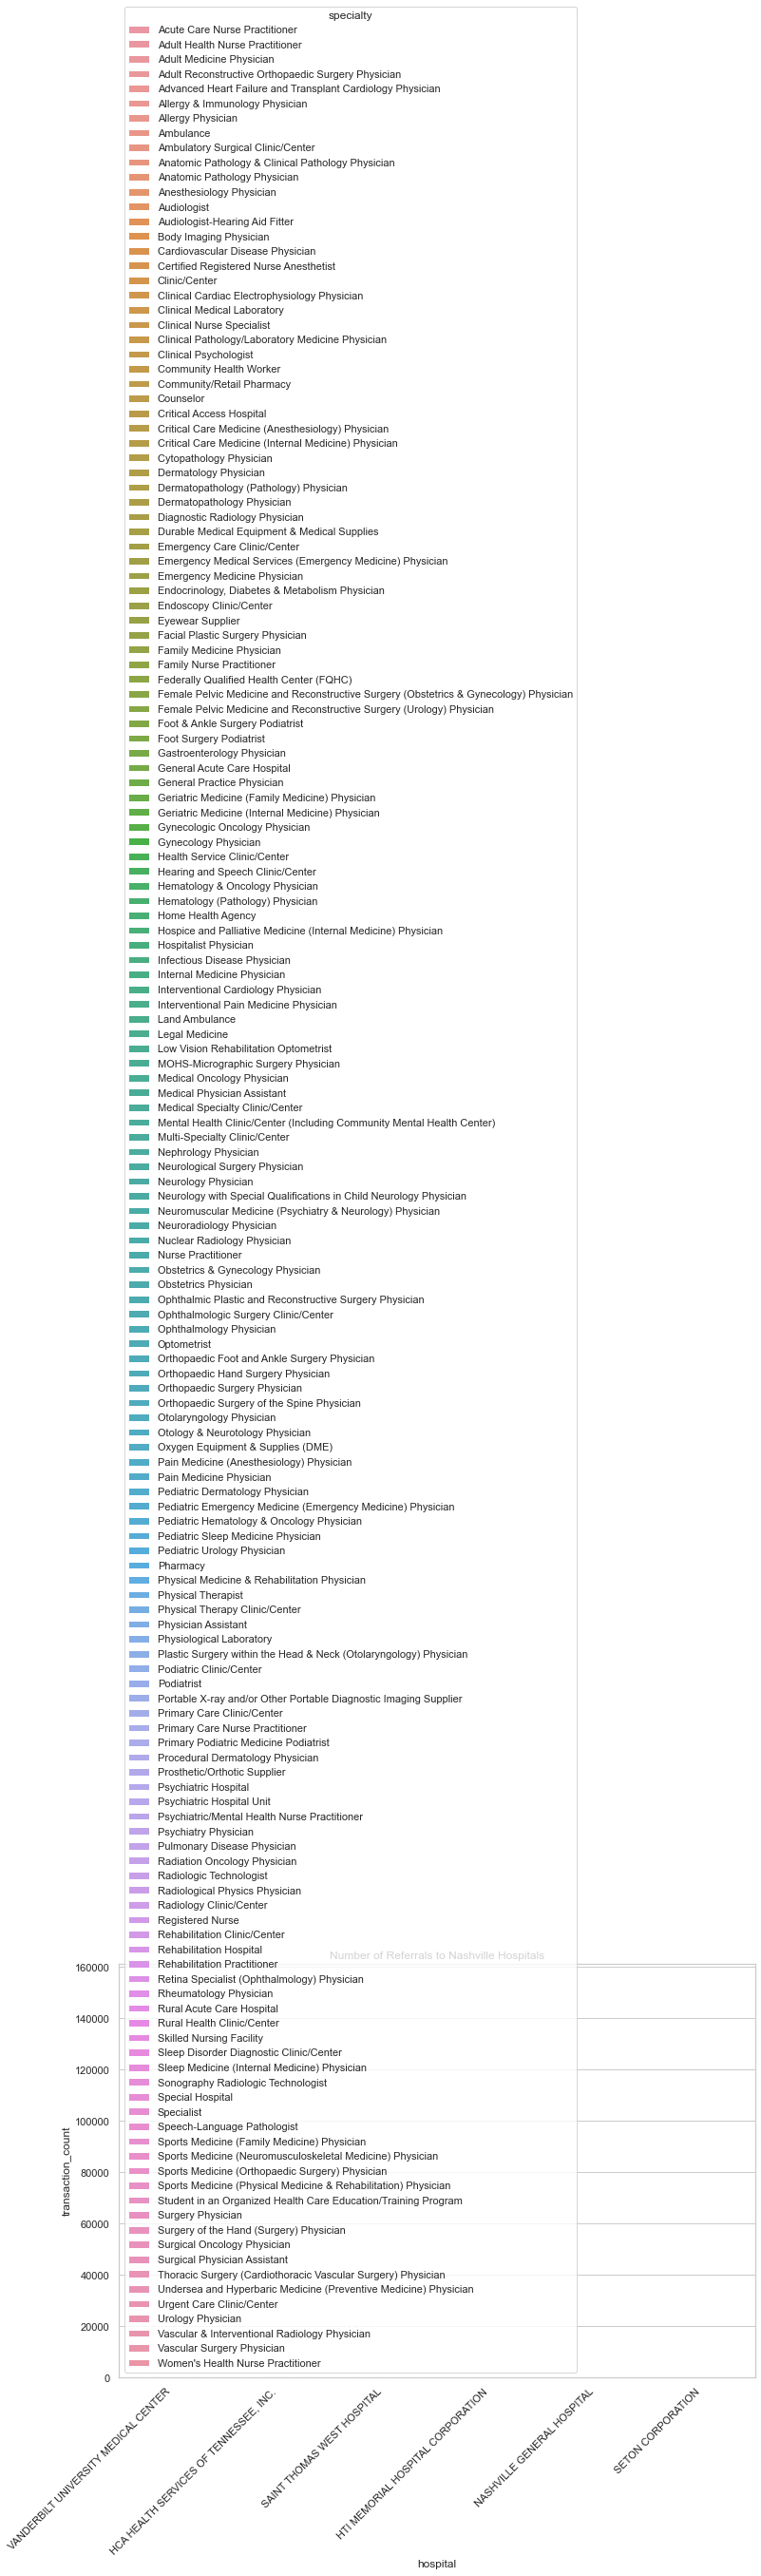

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

ax = sns.barplot(x="hospital", y="transaction_count", hue="specialty", data=specialties)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title("Number of Referrals to Nashville Hospitals")

plt.show()

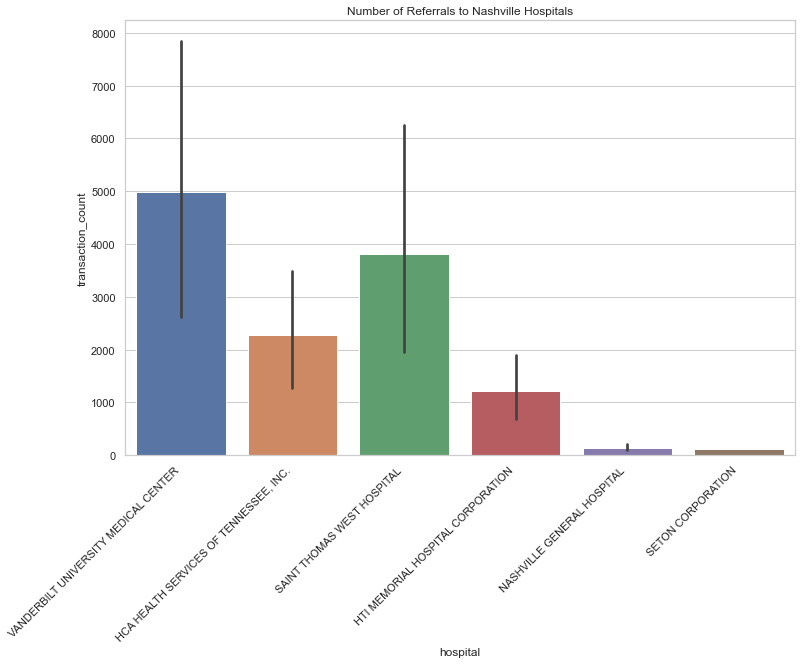

In [44]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

ax = sns.barplot(x="hospital", y="transaction_count", data=specialties)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title("Number of Referrals to Nashville Hospitals")

plt.show()

Text(0.5, 48.5, 'Hospital')

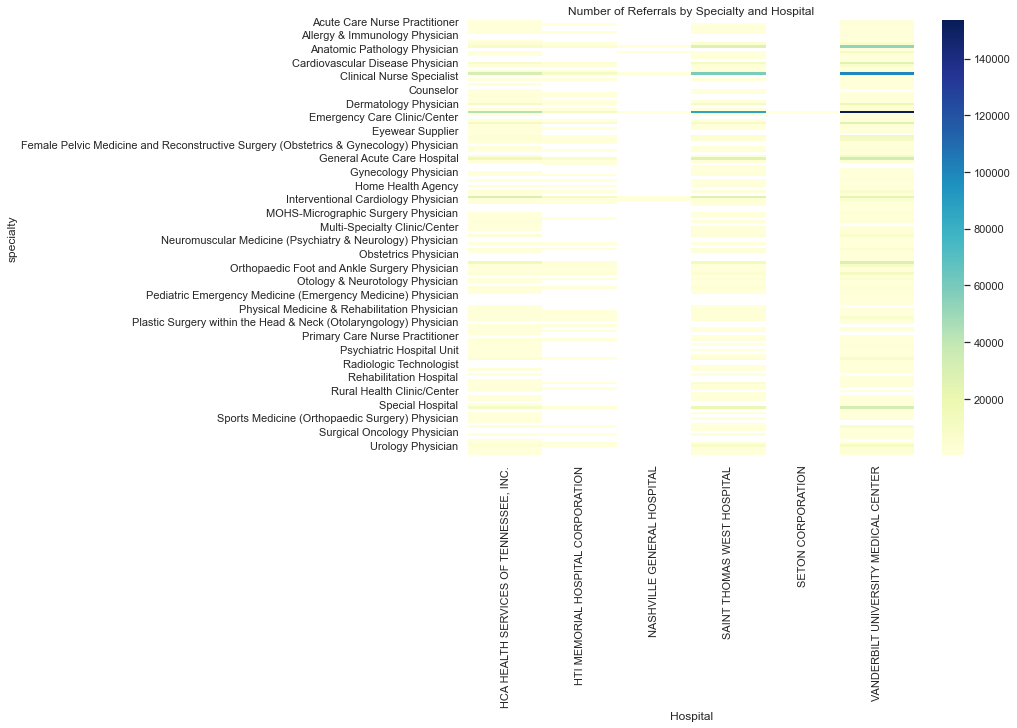

In [48]:
specialties_pivot = specialties.pivot(index='specialty', columns='hospital', values='transaction_count')

plt.figure(figsize=(10, 8))
sns.heatmap(specialties_pivot, cmap='YlGnBu', annot=False, fmt='.0f')
plt.title('Number of Referrals by Specialty and Hospital')
plt.xlabel('Hospital')